In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/func_0'
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 21.28 sec
brain shape is x,y,z,t (128, 92, 51, 4128)


In [3]:
z=25
X = brain[:,:,z,:].reshape(-1,brain.shape[-1]).T
print('X is time by voxels {}'.format(X.shape))

X is time by voxels (4128, 11776)


In [4]:
pca = PCA().fit(X)
pca_scores = pca.components_
print('Scores is PC by voxel {}'.format(pca_scores.shape))
pca_loadings = pca.transform(X)
print('Loadings is time by PC {}'.format(pca_loadings.shape))

Scores is PC by voxel (4128, 11776)
Loadings is time by PC (4128, 4128)


In [68]:
out=np.reshape(pca_scores, (-1, 128, 92))

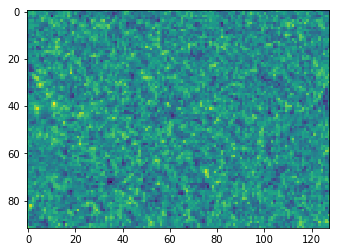

In [103]:
plt.imshow(out[52,:,:].T)

In [5]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 79.37 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 9.76 sec


In [366]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,25,3)
        dy = scipy.signal.savgol_filter(dy,25,3)
        dz = scipy.signal.savgol_filter(dz,25,3)
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,25,3)
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,25,3)
    else:
        print('invalid behavior')
    
    fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    ### INTERP TO EITHER TIMESTAMPS OR XNEW
    fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    #fictrac_interp = fictrac_interp_temp(xnew)

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [367]:
timestamps.shape

(4128, 51)

In [368]:
resolution = 50 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_for_prediction = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_for_prediction[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps)

(4128,)
(4128,)
(4128,)


In [369]:
np.shape(fictracs_for_prediction['all'])

(4128,)

In [8]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color='r',linestyle='--')

(0, 300)

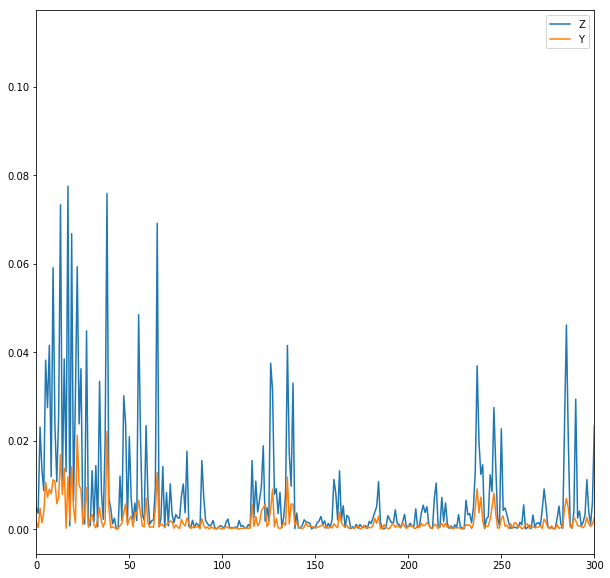

In [89]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Z'], label = 'Z')
plt.plot(fictracs['Y'], label = 'Y')
plt.legend()
plt.xlim(0,300)

(800, 1600)

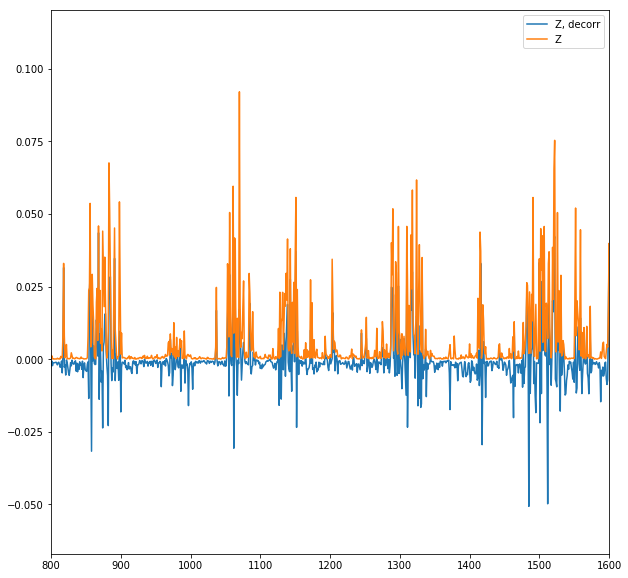

In [104]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Z_decorr'], label = 'Z, decorr')
plt.plot(fictracs['Z'], label = 'Z')
plt.legend()
plt.xlim(800,1600)

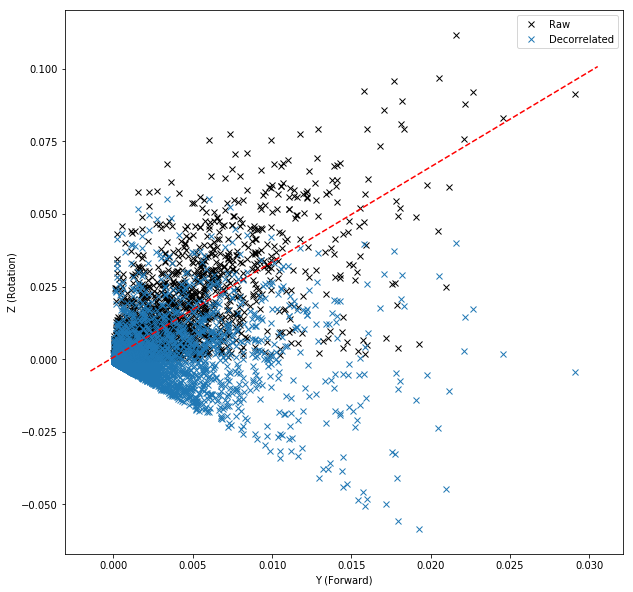

In [102]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Y'], fictracs['Z'],'x',color='k', label='Raw')
plt.plot(fictracs['Y'],fictracs['Z_decorr'],'x', label='Decorrelated')
plt.xlabel('Y (Forward)')
plt.ylabel('Z (Rotation)')
plt.legend()
abline(float(reg.coef_), float(reg.intercept_))

In [95]:

reg = linear_model.LinearRegression()

In [96]:
# Decorr Z
reg = linear_model.LinearRegression()
reg.fit(fictracs['Y'].reshape(-1,1), fictracs['Z'].reshape(-1,1))
out = reg.predict(fictracs['Y'].reshape(-1,1))
flat_list = [item for sublist in out for item in sublist]
fictracs['Z_decorr'] = fictracs['Z'] - flat_list

In [116]:
# Decorr Y
reg = linear_model.LinearRegression()
reg.fit(fictracs['Z'].reshape(-1,1), fictracs['Y'].reshape(-1,1))
out = reg.predict(fictracs['Z'].reshape(-1,1))
flat_list = [item for sublist in out for item in sublist]
fictracs['Y_decorr'] = fictracs['Y'] - flat_list

# Decorr Z
reg = linear_model.LinearRegression()
reg.fit(fictracs['Y'].reshape(-1,1), fictracs['Z'].reshape(-1,1))
out = reg.predict(fictracs['Y'].reshape(-1,1))
flat_list = [item for sublist in out for item in sublist]
fictracs['Z_decorr'] = fictracs['Z'] - flat_list

In [ ]:
# Now, every given Z has a predicted Y.
# For each timepoint, subtract the predicted Y from the actual Y

In [75]:
fictracs['Y_decorr']

array([-9.56673765e-05, -1.10763929e-03, -6.65298428e-05, ...,
       -5.44357109e-04, -5.02558502e-04, -5.48932211e-04])

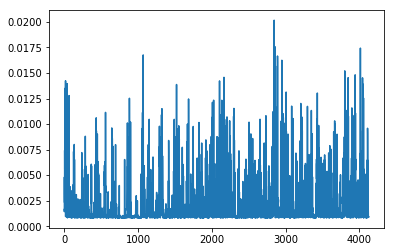

In [57]:
np.asarray(reg.predict(fictracs['Z'].reshape(-1,1)))

In [12]:
X_glm = pca_loadings[:,:100]

In [10]:
Y_glm = [fictrac_interp, fictrac_interp]

In [13]:
np.shape(Y_glm)

(4128, 2)

In [12]:
Y_glm = np.asarray(Y_glm).T

In [356]:
X_glm.shape

(4128, 100)

In [357]:
fictracs_for_prediction['all'].shape

(36000,)

In [370]:
# Predict for Y, as well as decorrelated Z

models = []
num_pcs = 100
for behavior in ['all']:
    Y_glm = fictracs_for_prediction[behavior]
    t0 = time()
    models.append({'behavior': behavior, 'model': LassoLarsIC(criterion='bic')})
    X_glm = pca_loadings[:,:num_pcs]
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time()-t0))

Num PCs: 100, Duration: 0.049401044845581055 sec


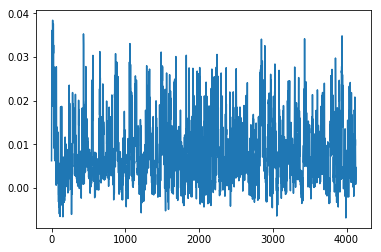

In [375]:
plt.plot(models[-1]['model'].predict(X_glm))

In [94]:
# MANUAL LASSO ALPHA

models = []
num_pcs = 100
X_glm = pca_loadings[:,:num_pcs]
for behavior in ['Y', 'Z']:
    Y_glm = fictracs[behavior]

    if behavior in ['Y', 'Y_decorr']:
        alpha = 3e-4
    if behavior in ['Z', 'Z_decorr']:
        alpha = 10e-4
    models.append({'behavior': behavior, 'model': linear_model.Lasso(alpha=alpha)})
    
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)

In [ ]:
# Lets make alpha sweep graphs

Y_glm = fictracs['Y']
models = []
num_pcs = 100
for behavior in ['all', 'Y', 'Y_decorr', 'Z', 'Z_decorr']:
    Y_glm = fictracs[behavior]
    for alpha in [1,.1,.01,.001,.0001,.00001]:
    models.append({'behavior': behavior, 'model': linear_model.Lasso(alpha=.01), 'model_type': 'LassoLarsIC'})
    
    X_glm = pca_loadings[:,:num_pcs]
    
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)


Text(0.5, 1.0, '5-fold CV Lasso alpha. Vertical is 10e-4. Behavior = Z_decorr')

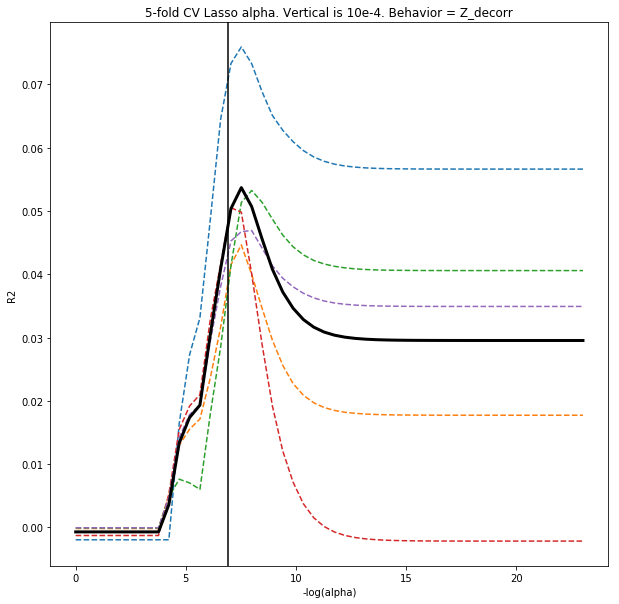

In [301]:
kf = KFold(n_splits=5, shuffle=True)
X = X_glm
y = fictracs['Z_decorr']
alphas = np.logspace(0,-10)
models = []

for train_index, test_index in kf.split(X):

    # Get training and test data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # For this given split, sweep alphas
    models.append([])
    for alpha in alphas:
        model = linear_model.Lasso(alpha=alpha).fit(X_train, y_train)
        models[-1].append(model.score(X_test, y_test))

plt.figure(figsize=(10,10))
for fold in models:
    plt.plot(-np.log(alphas),fold,linestyle='--')
plt.plot(-np.log(alphas),np.mean(np.asarray(models),axis=0),color='k',linewidth=3)
plt.axvline(-np.log(10e-4),color='k')
plt.xlabel('-log(alpha)')
plt.ylabel('R2')
plt.title('5-fold CV Lasso alpha. Vertical is 10e-4. Behavior = Z_decorr')

In [95]:
# MANUAL LASSO ALPHA


X_glm = pca_loadings[:,:num_pcs]
Y_glm = fictracs['Z']

    if behavior in ['Y', 'Y_decorr']:
        alpha = 3e-4
    if behavior in ['Z', 'Z_decorr']:
        alpha = 10e-3
    models.append({'behavior': behavior, 'model': linear_model.Lasso(alpha=alpha)})
    
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)

IndentationError: unexpected indent (<ipython-input-95-bfb3bc8b7b25>, line 7)

Text(0.5, 0.98, 'Regularization: LassoLarsIC(BIC)')

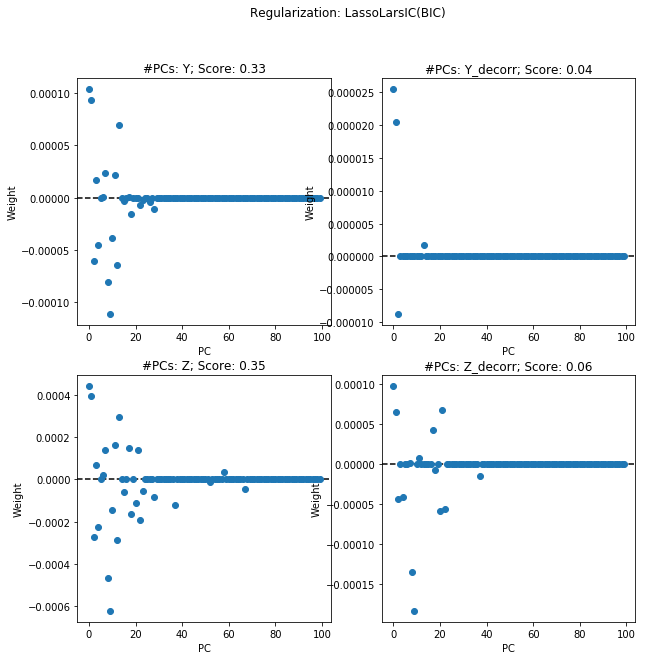

In [303]:
plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(model['model'].coef_,'o')
    plt.title ('#PCs: {}; Score: {:.2f}'.format(model['behavior'], model['score']))
    plt.ylabel('Weight')
    plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoLarsIC(BIC)')

In [97]:
Y_norm = (models[0]['model'].coef_)/np.std(models[0]['model'].coef_)
Z_norm = (models[1]['model'].coef_)/np.std(models[1]['model'].coef_)

Text(0.5, 1.0, 'Fold difference')

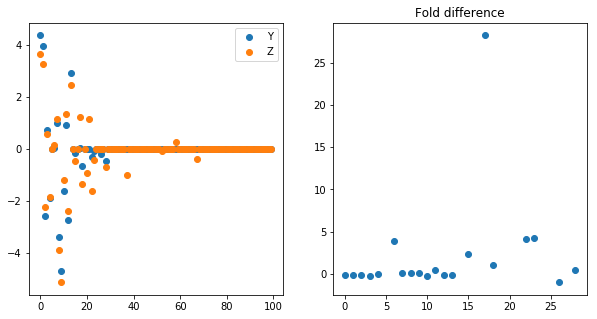

In [98]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(Y_norm,'o',label='Y')
plt.plot(Z_norm,'o',label='Z')
plt.legend()
plt.subplot(122)
plt.plot(((Z_norm-Y_norm)/Y_norm),'o')
plt.title('Fold difference')

Text(0.5, 1.0, 'Normalized Y and Z coefs')

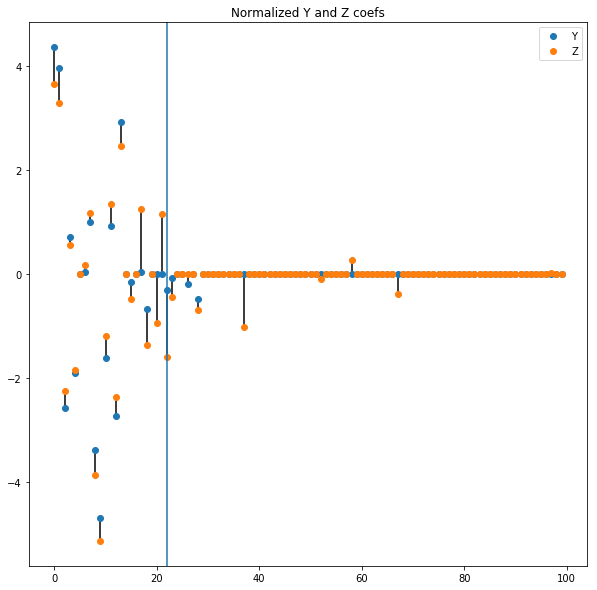

In [113]:
plt.figure(figsize=(10,10))

for i in range(len(Y_norm)):
    plt.plot([i,i],[Y_norm[i],Z_norm[i]],'k')

plt.plot(Y_norm,'o',label='Y')
plt.plot(Z_norm,'o',label='Z')
plt.axvline(22)
plt.legend()
plt.title('Normalized Y and Z coefs')

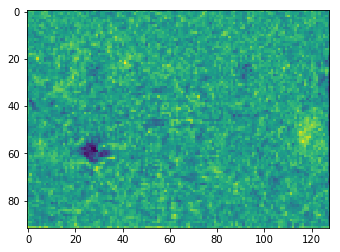

In [115]:
plt.imshow(out[21,:,:].T)

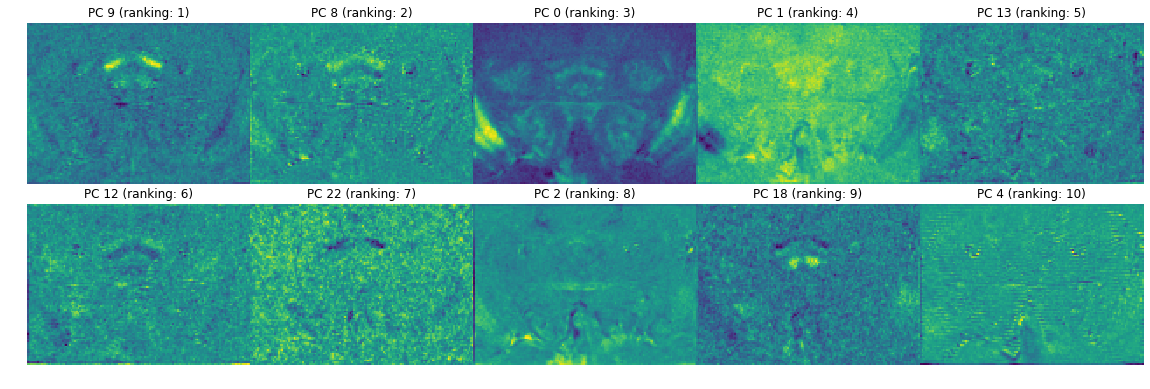

In [145]:
plt.figure(figsize=(20,10))
PCs = np.argsort(Z_ranks)[:10]
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(out[PCs[i],:,:].T)
    plt.axis('off')
    plt.title('PC {} (ranking: {})'.format(PCs[i],i+1))
plt.subplots_adjust(wspace=0, hspace=-.5)

Text(0.5, 1.0, 'Fold difference')

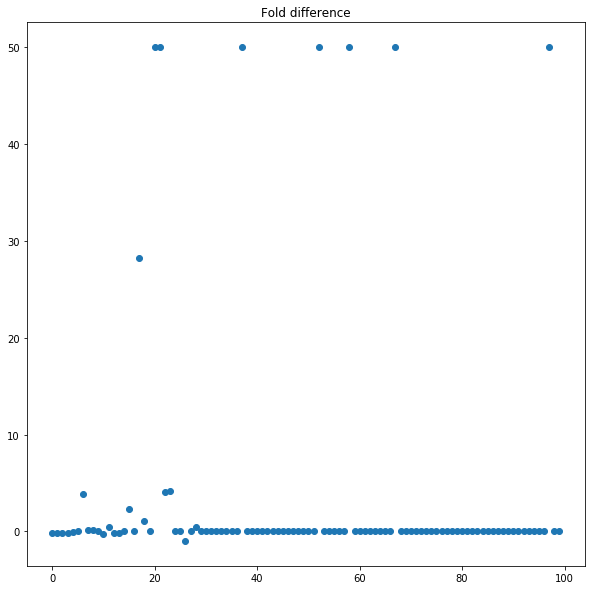

In [321]:
plt.figure(figsize=(10,10))

out = np.divide((Z_norm-Y_norm),Y_norm)

where_r_nans = np.isnan(out)
out[where_r_nans] = 0

where_r_inf = np.isinf(out)
out[where_r_inf] = 50

plt.plot(out,'o',label='Y')
plt.title('Fold difference')

In [ ]:
# How to do unique variance explained?
# Remove the PC column, rerun glm, see how much score dropped?

In [9]:
from sklearn.feature_selection import SelectFromModel

NameError: name 'X_transform' is not defined

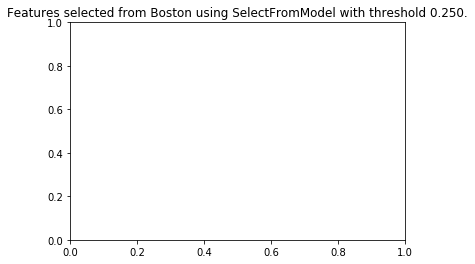

In [30]:
y = fictracs['Y']
X = X_glm

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV(cv=5)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 2:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

# Plot the selected two features from X.
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

In [56]:
y = fictracs['Z']
X = X_glm

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
estimator = LassoCV(cv=5)

selector = RFE(estimator, 1, step=1)
selector = selector.fit(X, y)

In [57]:
Z_ranks = selector.ranking_

In [60]:
Z_ranks

array([  3,   4,   8,  30,  10,  58,  44,  17,   2,   1,  16,  13,   6,
         5,  42,  22,  50,  11,   9,  53,  15,  12,   7,  20,  64,  91,
        29,  48,  18,  55,  59,  36,  94,  96,  97,  70,  57,  14,  82,
        56,  78,  85,  84,  67,  65,  47,  63,  88,  28, 100,  99,  95,
        23,  49,  43,  89,  61,  90,  21,  77,  37,  34,  92,  51,  79,
        83,  41,  19,  32,  38,  39,  75,  45,  52,  73,  76,  87,  93,
        26,  68,  80,  71,  60,  33,  86,  69,  72,  62,  66,  81,  35,
        46,  54,  40,  74,  25,  31,  24,  27,  98])

(0, 30)

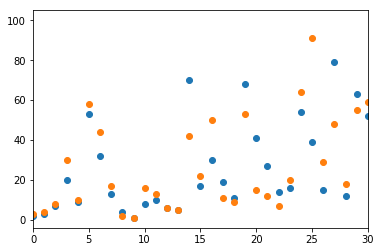

In [65]:
plt.plot(Y_ranks,'o')
plt.plot(Z_ranks,'o')
plt.xlim(0,30)

Text(0.5, 1.0, 'Reverse selection')

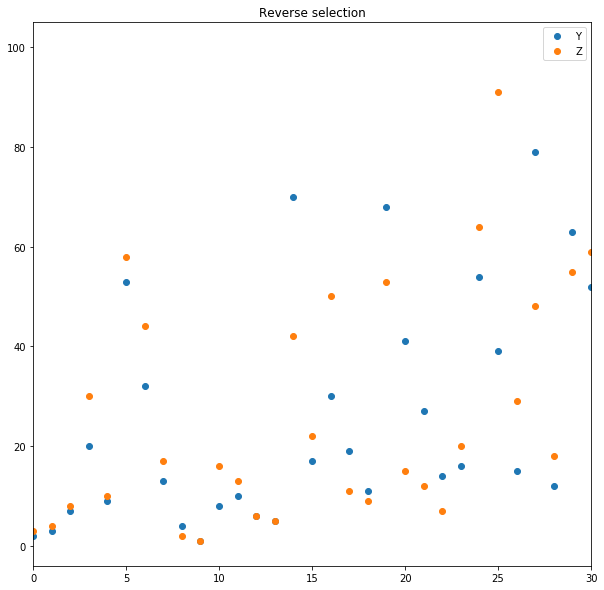

In [118]:
plt.figure(figsize=(10,10))
plt.plot(Y_ranks,'o',label='Y')
plt.plot(Z_ranks,'o',label='Z')
plt.xlim(0,30)
plt.legend()
plt.title('Reverse selection')

In [130]:
np.argsort(Y_ranks)[:10]

array([ 9,  0,  1,  8, 13, 12,  2, 10,  4, 11])

In [121]:
Z_ranks

array([  3,   4,   8,  30,  10,  58,  44,  17,   2,   1,  16,  13,   6,
         5,  42,  22,  50,  11,   9,  53,  15,  12,   7,  20,  64,  91,
        29,  48,  18,  55,  59,  36,  94,  96,  97,  70,  57,  14,  82,
        56,  78,  85,  84,  67,  65,  47,  63,  88,  28, 100,  99,  95,
        23,  49,  43,  89,  61,  90,  21,  77,  37,  34,  92,  51,  79,
        83,  41,  19,  32,  38,  39,  75,  45,  52,  73,  76,  87,  93,
        26,  68,  80,  71,  60,  33,  86,  69,  72,  62,  66,  81,  35,
        46,  54,  40,  74,  25,  31,  24,  27,  98])

In [50]:
selector.get_params

<bound method BaseEstimator.get_params of RFE(estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
  n_features_to_select=5, step=1, verbose=0)>

(1000, 1400)

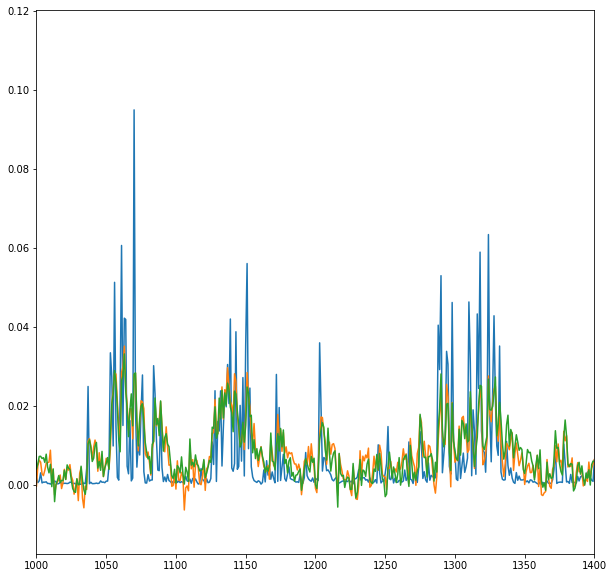

In [89]:
plt.figure(figsize=(10,10))
plt.plot(Y_glm)
plt.plot(models[0]['model'].predict(pca_loadings[:,:10]))
plt.plot(models[1]['model'].predict(pca_loadings[:,:100]))
plt.xlim(1000,1400)

Text(0.5, 0.98, 'Regularization: LassoLarsIC(BIC)')

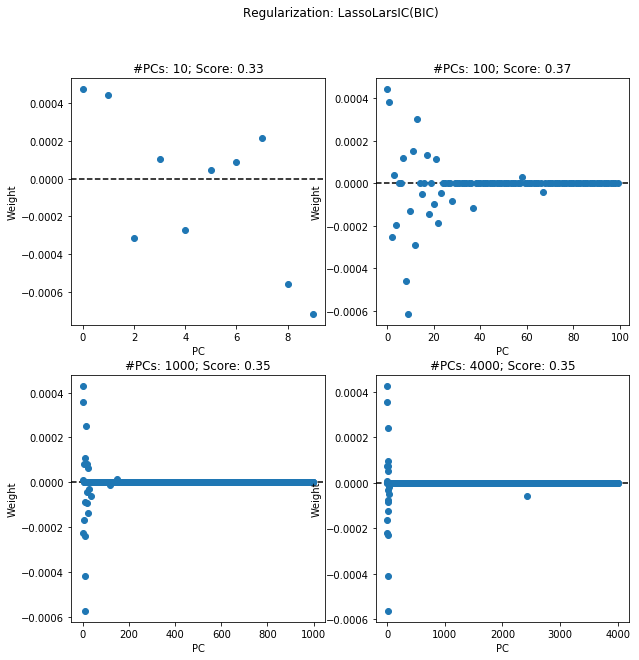

In [74]:
plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(model['model'].coef_,'o')
    plt.title ('#PCs: {}; Score: {:.2f}'.format(model['num_pcs'], model['score']))
    plt.ylabel('Weight')
    plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoLarsIC(BIC)')

Text(0.5, 0.98, 'Regularization: LassoCV')

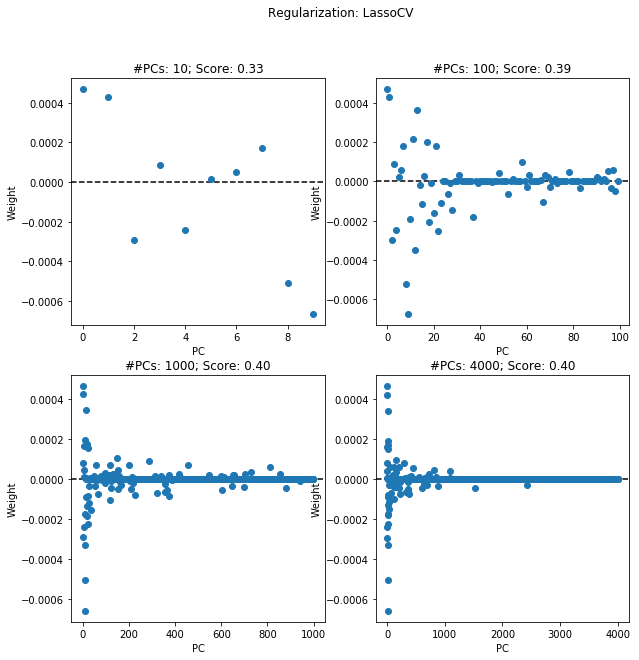

In [69]:
plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(model['model'].coef_,'o')
    plt.title ('#PCs: {}; Score: {:.2f}'.format(model['num_pcs'], model['score']))
    plt.ylabel('Weight')
    plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoCV')

In [35]:
Y_glm = fictrac_interp
X_glm_1000 = pca_loadings[:,:1000]

In [50]:
t0 = time()
model_1000 = LassoCV()
model_1000.fit(X_glm_1000, Y_glm)
print('Duration: {} sec'.format(time()-t0))

NameError: name 'X_glm_100' is not defined

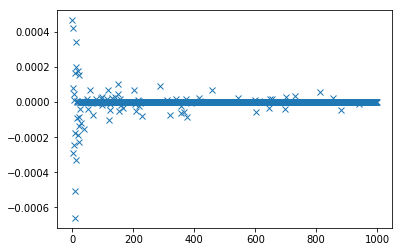

In [48]:
plt.plot(model_1000.coef_,'x')

In [49]:
model_1000.score(X_glm_1000,Y_glm)

0.40009402891821844

In [26]:
pca_scores_reshaped = np.reshape(pca_scores, (-1,dims['y'],dims['x']))
print('new shape: {}'.format(pca_scores_reshaped.shape))

new shape: (4128, 128, 92)


# Switching to statsmodels for link function

In [194]:
X_glm = sm.add_constant(np.nan_to_num(pca_loadings[:,:100]), prepend=False)

In [195]:
Y_glm = fictrac_interp

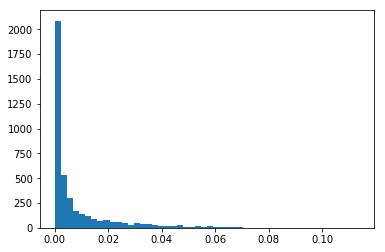

In [161]:
plt.hist(Y_glm,bins=50);

In [261]:
model = sm.GLM(y, X, family=sm.families.Poisson())

In [278]:
model_results = model.fit_regularized(method='elastic_net', L1_wt=1, alpha=.001)

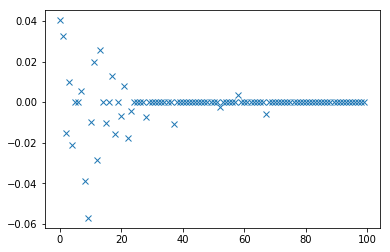

In [279]:
plt.plot(model_results.params[:-1],'x')

In [188]:
model_results = model.fit()

In [228]:
from sklearn.metrics import mean_squared_error

In [252]:
mean_squared_error(out,Y_glm)

0.0001137721573853367

In [259]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
X = X_glm
y = Y_glm

MSE_all = []
i=0
for train_index, test_index in kf.split(X):
    if i==0:
        i+=1
        print(i)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = sm.add_constant(X_train, prepend=False)
        model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
        MSE = []
        for alpha in [0,.1,.01,.001,.0001,.00001,.000001,.0000001]:
            model_results = model.fit_regularized(method='elastic_net', alpha=alpha)
            y_predicted = model_results.predict(X_test)
            MSE.append(mean_squared_error(y_predicted, y_test))
        MSE_all.append(MSE)
        #r2s.append(sklearn.metrics.r2_score(y_test, y_predicted))

1


In [257]:
MSE_all[0]

[0.00014965928500862812,
 0.010058965306480459,
 0.00024357615531764293,
 0.00014202493124954577,
 0.00014558185952353212]

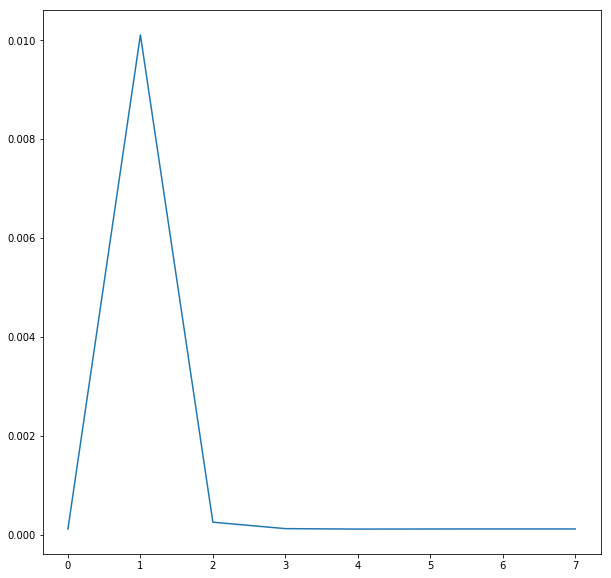

In [260]:
plt.figure(figsize=(10,10))
plt.plot(MSE_all[0])

In [250]:
np.mean(r2s)

0.34117338830967847

In [213]:
model_results = model.fit_regularized(method='elastic_net', alpha=.001)

In [215]:
out = model_results.predict(X_glm)

In [227]:
sklearn.metrics.r2_score(Y_glm, out)

0.3855329983355378

(2000, 2400)

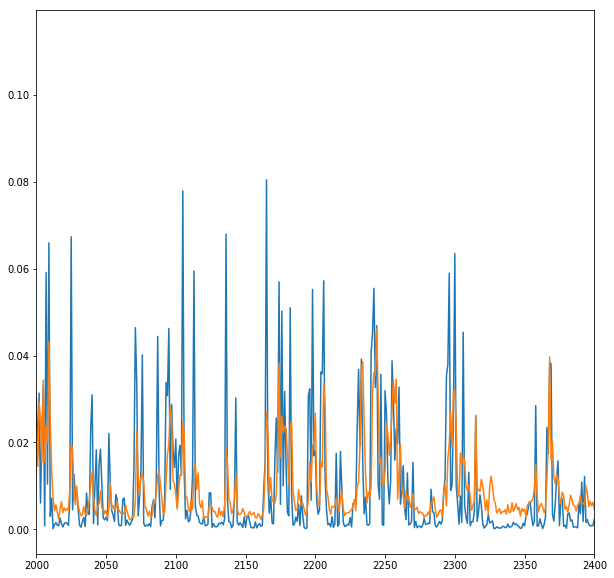

In [217]:
plt.figure(figsize=(10,10))
plt.plot(Y_glm)
plt.plot(out)
plt.xlim(2000,2400)

In [237]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(method='elastic_net', alpha=.001)
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [238]:
cross_val_score(SMWrapper(sm.GLM), X_glm, Y_glm, scoring='r2')

array([0.20644287, 0.33814884, 0.2989024 ])

# Movie time

In [8]:
### Load Video ###
cap = cv2.VideoCapture(os.path.join(directory, 'fictrac', 'fictrac-20190226_124612-raw.avi'))
i=0
frames = []
ret = True
while ret is True and i<40000:
    i+=1
    if i%1000 == 0:
        print(i)
    # Capture frame-by-frame
    ret, frame = cap.read()
    frames.append(frame)
cap.release()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000


In [10]:
def round_down_to_base(x, base=20):
    return [math.floor(i/base) for i in x]
indicies = round_down_to_base(timestamps[:,25])
timestamps_expaned = np.zeros((len(fictracs['Y'])))

In [11]:
file = os.path.join(directory, 'motcorr', 'motcorr_green.nii')
meanbrain = bbb.load_numpy_brain(file)
meanbrain = np.mean(meanbrain,axis=-1)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 3.85 min


In [18]:
pca_spatial = np.reshape(pca_scores, (-1, 128,92))

In [33]:
fictrac_times = np.arange(0,expt_len,1/fps*1000)
pca_interp_temp = interp1d(timestamps[:,25], pca_loadings[:,0], bounds_error = False)
pca_interp = pca_interp_temp(fictrac_times)

In [188]:
fictrac_times = np.arange(0,expt_len,1/fps*1000)
pca_interp_temp = interp1d(timestamps[:,25], pca_loadings.T, bounds_error = False)
pca_interp = pca_interp_temp(fictrac_times)

In [405]:
pca_interp.shape

(4128, 90000)

(0, 100)

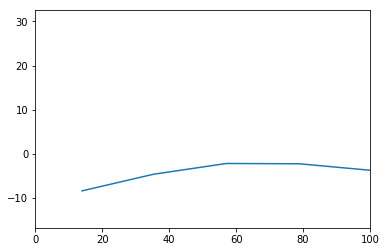

In [413]:
plt.plot(pca_interp[4,:])
plt.xlim(0,100)

In [415]:
np.std(np.nan_to_num(pca_interp[4,:]))

4.8399934570148755

In [427]:
def plot_brain_activity(ax, meanbrain, pca_spatial, pca_interp):
    ax.axis('off')
    ax.imshow(meanbrain,cmap='gray')
    activity = np.multiply(pca_spatial, pca_interp)

    # Create an alpha channel based on weight values
    # Any value whose absolute value is > value will have zero transparency
    important_number = .25 # This value really changes how alpha channel overlay looks
    alphas = Normalize(.2, important_number, clip=True)(activity)
    alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom

    # Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
    colors = Normalize(0, 1)(activity)
    cmap = plt.cm.hot
    colors = cmap(colors)

    # Now set the alpha channel to the one we created above
    colors[..., -1] = alphas
    ax.imshow(colors[:,:],alpha=1)

In [376]:
predicted_behavior = models[-1]['model'].predict(X_glm)

In [379]:
xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [382]:
interp_temp = interp1d(timestamps[:,25], predicted_behavior, bounds_error = False)
xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
predicted_behavior_interp = interp_temp(xnew)

In [383]:
predicted_behavior_interp.shape

(36000,)

In [378]:
fictracs['all'].shape

(36000,)

In [ ]:
fig = plt.figure(figsize=(15,10))
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/func_0/movie_20190820-1822'
ms_to_min = 1000*60
PCs = [9, 8, 0, 1, 13, 12, 22, 2, 18, 4]

for i in range(0,40000,2):
    #i=300
    plt.clf()
    print(i)


    ###### PLOT BRAIN ACTIVITIES OF SINGLE PCS ######
    ax_brains = []
    right_shift = .24
    down_shift = .26
    for j, PC in enumerate(PCs):
        if j < 5:
            y_loc = 2
            x_loc = right_shift*(j+1)
        else:
            y_loc = 2-down_shift
            x_loc = right_shift*(j-4)
        ax_brains.append(fig.add_axes([x_loc, y_loc, .25, .25]))
        plot_brain_activity(ax_brains[-1], meanbrain[:,:,25].T, pca_spatial[PC,:,:].T*10, pca_interp[PC,i]/np.std(np.nan_to_num(pca_interp[PC,:])))
        ax_brains[-1].text(0,8,'PC {}'.format(PC),fontsize=18,color='white')


    ###### PLOT MASTER BRAIN ACTIVITY ######
    ax_master_brain = fig.add_axes([.233, 1.28, .45, .45])
    out = []
    for PC in PCs:
        out.append(np.multiply(pca_spatial[PC,:,:].T, pca_interp[PC,i]))
    master_activity = np.mean(out, axis=0)
    plot_brain_activity(ax_master_brain, meanbrain[:,:,25].T, master_activity*5, 1)


    ###### PLOT FLY VIDEO ######
    ax_fly = fig.add_axes([.584, 1.28, 0.45, 0.45])
    ax_fly.axis('off')
    ax_fly.imshow(frames[i][:300,280:550,:])


    ###### PLOT PC TEMPORAL ######
    ax3 = fig.add_axes([.92, 1.28, 0.50, 0.45])
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.yaxis.set_visible(False)
    plt.xlabel('Time, min')
    plt_idx = i*20/ms_to_min
    height_offset = 20
    for j, PC in enumerate(PCs[::-1]):
        #plt.plot(pca_interp[i,:]+i*20)
        ax3.axhline(j*height_offset, linestyle='--',color='grey')
        ax3.plot(timestamps[:,25]/ms_to_min,pca_loadings[:,PC]+(j*height_offset),label='PC{}'.format(PC))
        ax3.text(-.8,(j*height_offset)+2,'PC {}'.format(PC),fontsize=18)
    ax3.axvline(plt_idx,color='k',linestyle='--')
    offset = 2
    plt.xlim(plt_idx-offset,plt_idx+offset)
    #plt.ylim(-20,200)


    ###### PLOT BEHAVIOR PREDICTION ######
    ax_behavior = fig.add_axes([.28, 1, 1.1, 0.25])
    ax_behavior.plot(xnew/ms_to_min, fictracs['all'],label='Behavior',color='k')
    plt.plot(xnew/ms_to_min, predicted_behavior_interp,label='Predicted',color='r')

    plt_idx = i*20/ms_to_min
    ax_behavior.axvline(plt_idx,color='k',linestyle='--')
    offset = 1
    plt.xlim(plt_idx-offset,plt_idx+offset)
    plt.ylabel('Fly velocity')
    plt.xlabel('Time, min')
    plt.legend()

    plt.subplots_adjust(wspace=.02, hspace=0)
    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=100,bbox_inches='tight')

0
2
4
6


In [396]:
np.std(pca_interp[4,:])

nan

In [404]:
pca_interp.shape

(4128, 90000)

In [315]:
PCs[::-1]

[4, 18, 2, 22, 12, 13, 1, 0, 8, 9]

In [ ]:
activity = np.multiply(pca_spatial[PC,:,:].T, pca_interp[PC,i])

In [304]:
pca_loadings.shape

(4128, 4128)

In [267]:
pca_scores.shape

(4128, 11776)

In [268]:
pca_spatial.shape

(4128, 128, 92)

In [ ]:
#so, take the 10 spatial PCs, for each multiply it by its temporal score, then add them all together

In [281]:
PCs

[9, 8, 0, 1, 13, 12, 22, 2, 18, 4]

In [286]:
brains = []
i=200
out=[]
for PC in PCs:
    out.append(np.multiply(pca_spatial[PC,:,:].T, pca_interp[PC,i]))

PC interp 15.680296697910808
PC interp 2.167096020954295
PC interp 42.41038351423181
PC interp 25.38798031594831
PC interp -2.7691322227471025
PC interp 5.054071731852694
PC interp 4.982568619577902
PC interp -22.396007221449153
PC interp -0.27925733689320187
PC interp -4.114834897166956


In [295]:
out[0].shape

(92, 128)

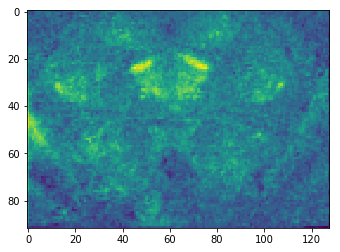

In [303]:
out2 = np.multiply(np.mean(out, axis=0), 1)
plt.imshow(out2)

In [271]:
out = np.multiply(np.squeeze(pca_spatial[[PCs],:,:]), np.squeeze(pca_loadings[:,[PCs]]))

ValueError: operands could not be broadcast together with shapes (10,128,92) (4128,10) 

In [176]:
for i,j in enumerate([5,4,3]):
    print(i)

0
1
2


(0, 500)

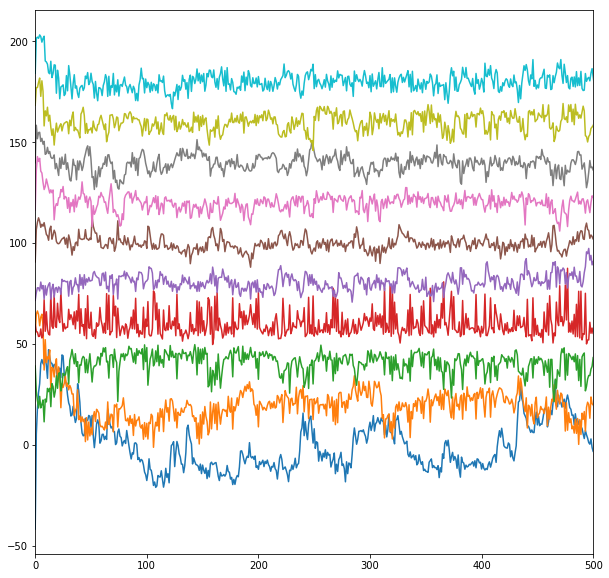

In [191]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.plot(pca_loadings[:,i]+i*20)
plt.xlim(0,500)

(0, 10000)

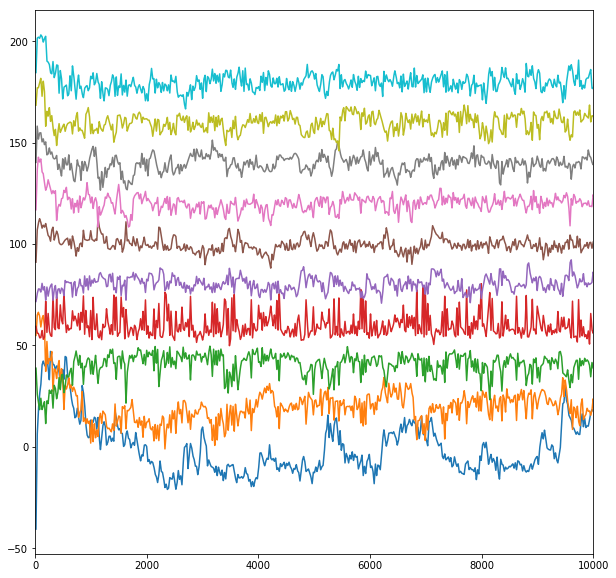

In [193]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.plot(pca_interp[i,:]+i*20)
plt.xlim(0,10000)